In [1]:
import dotenv
import os 

dotenv.load_dotenv("azure.env")

True

In [2]:
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage, TextContentItem, ImageContentItem, ImageUrl, ImageDetailLevel


client = ChatCompletionsClient(
  endpoint=os.getenv("PHI_ENDPOINT"),
  credential=AzureKeyCredential(os.getenv("PHI_API_KEY")),
)


In [3]:
os.getenv("PHI_ENDPOINT")

'https://phi-3-vision.eastus.inference.ml.azure.com'

In [4]:
from PIL import Image, ImageDraw, ImageFont
import math
import base64
import os

def add_grid_overlay(image_path):
    # Load the image
    image = Image.open(image_path)

    # Get the dimensions of the image
    width, height = image.size

    # Calculate the coordinates for cropping
    left = (width - 300) // 2
    top = (height - 500) // 2
    right = (width + 250) // 2
    bottom = (height + 500) // 2

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    # Create a draw object
    draw = ImageDraw.Draw(cropped_image)

    # Define the font and size for the grid numbers
    font_size = 16
    font = ImageFont.load_default(font_size)

    # Define the grid size and spacing
    grid_size = 16
    d = int(math.sqrt(grid_size))
    grid_spacing = cropped_image.width // d
    grid_spacing_height = cropped_image.height // d

    # Draw the grid overlay
    for i in range(d):
        x = i * grid_spacing
        y = i * grid_spacing_height
        draw.line([(x, 0), (x, cropped_image.height)], fill=(255, 0, 0), width=2)
        draw.line([(0, y), (cropped_image.width, y)], fill=(255, 0, 0), width=2)

    for i in range(grid_size):
        x = (i  % d) * grid_spacing
        y = (i // d) * grid_spacing_height
        draw.text((x + 5, y + 5), str(i + 1), fill=(255, 0, 0), font=font)
    
    #cropped_image.show()
    # Display the cropped image with grid overlay
    #cropped_image.show()
    file_name = os.path.basename(image_path)
    file_name = file_name.replace('.jpg', '.png')
    # Convert the cropped image to base64
    file_path = os.path.join('cropped', file_name)
    if not os.path.exists(file_path):
        cropped_image.save(file_path)
    return os.path.join('cropped',file_name)


In [5]:
add_grid_overlay('/home/vhoudebine/azure_openai/nasdaq-vision/image/screenshot_20240628135059.png')

'cropped/screenshot_20240628135059.png'

In [5]:
import os
import base64

def open_image_to_base64(file_path):
    with open(file_path, "rb") as image_file:
        image_data = image_file.read()
        base64_data = base64.b64encode(image_data).decode("utf-8")
        base64_url = f"data:image/png;base64,{base64_data}"
        return base64_url


def process_images(image_folder):
  image_files = os.listdir(image_folder)
  image_files.sort(reverse=False)
  base64_images = []
  for file in image_files:
    if file.endswith('.jpg') or file.endswith('.png'):
      file_path = os.path.join(image_folder,file)
      cropped_image_path = add_grid_overlay(file_path)
      base64_url = open_image_to_base64(cropped_image_path)
      image_dict = {
          'file_name': file,
          'base64_url': base64_url
        }
      base64_images.append(image_dict)
    
  return base64_images

image_folder = 'image'
base64Frames = process_images(image_folder)
base64Urls = [image['base64_url'] for image in base64Frames]


[{'type': 'text', 'text': 'describe this image'}, [{'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]]

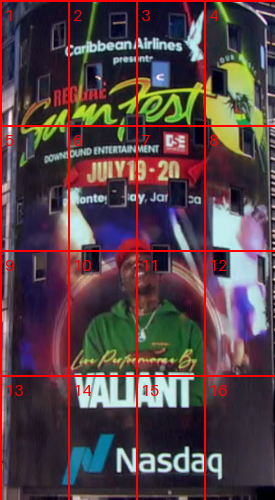

HttpResponseError: (400) Multiple 'image_url' input is currently not supported.
Code: 400
Message: Multiple 'image_url' input is currently not supported.

In [11]:
prompt = """Here is a series of 10 frames from a video of a building with screen displaying video ads
Your role is to monitor the screen and analyze the ads and detect any defect.

the images have a grid with 16 sections drawn in red with the number of the grid in the upper left corner from 1 to 16.

These are example defects that can happen:
- one section of the screen stays static across the 10 frames
- all the screen stays static across the 10 frames

The building is in the middle of the picture it has windows and screens all around. Windows are always static.
Only analyze the building screen, ignore all the other parts of the image and all other buildings and signs.
There is a Nasdaq logo at the bottom of the screen, it is always static, don't consider it as an ad and don't include it in any text extraction.

Your role is to:
1. Analyze each grid section independently and for each of the section, tell me if there is movement across the 10 frames
2. Analyze the whole building and tell me if there is a defect affecting the whole screen
3. Identify the different video ads on the screen and summarize the content of each ad, who is it for and what is the main message.
4. Classify each frame into the ad displayed on the screen



Return a JSON with the following structure 
{"screen": {"defect":"Yes/No", "reason":"explain why you think there is a defect"},
"individual_sections":[{"number":1, "defect":"yes/no", "reason":"explain why you thinkt here is a defect"}],
"ads": [{"advertiser": "Name of the advertiser for the ad", "summary": "description of the ad"}, ...],
"frames": [{"frame_number":1,"description":"visual description of the screen", "advertiser": "Name of the advertiser for the ad", "text": "the text displayed on the ad"}, ...],

}

"""
imageurls = [ImageContentItem(image_url=ImageUrl(url=url,
                                                 detail=ImageDetailLevel.HIGH)) for url in base64Urls[:1]]
usercontent = [TextContentItem(text="describe this image")] 
usercontent.append(imageurls)
print(usercontent)
response = client.complete(
    messages = [
        SystemMessage(content = "You are a helpful image assistant that can analyze images"),
        UserMessage(content = [
            TextContentItem(text = "describe these two images, is there any change on the screen between the two"),
            ImageContentItem(image_url=ImageUrl(url=base64Urls[0], detail=ImageDetailLevel.HIGH)),
            ImageContentItem(image_url=ImageUrl(url=base64Urls[1], detail=ImageDetailLevel.HIGH)),
        ])
    ],
    stream=False
)


print(response.choices[0].message.content)

In [71]:
prompt = """Here is a series of 10 frames from a video of a building with screen displaying video ads
Your role is to monitor the screen and analyze the ads and detect any defect.

the images have a grid with 16 sections drawn in red with the number of the grid in the upper left corner from 1 to 16.

These are example defects that can happen:
- one section of the screen stays static across the 10 frames
- all the screen stays static across the 10 frames

The building is in the middle of the picture it has windows and screens all around. Windows are always static.
Only analyze the building screen, ignore all the other parts of the image and all other buildings and signs.
There is a Nasdaq logo at the bottom of the screen, it is always static, don't consider it as an ad and don't include it in any text extraction.

Your role is to:
1. Analyze each grid section independently and for each of the section, tell me if there is movement across the 10 frames
2. Analyze the whole building and tell me if there is a defect affecting the whole screen
3. Identify the different video ads on the screen and summarize the content of each ad, who is it for and what is the main message.
4. Classify each frame into the ad displayed on the screen



Return a JSON with the following structure 
{"screen": {"defect":"Yes/No", "reason":"explain why you think there is a defect"},
"individual_sections":[{"number":1, "defect":"yes/no", "reason":"explain why you thinkt here is a defect"}],
"ads": [{"advertiser": "Name of the advertiser for the ad", "summary": "description of the ad"}, ...],
"frames": [{"frame_number":1,"description":"visual description of the screen", "advertiser": "Name of the advertiser for the ad", "text": "the text displayed on the ad"}, ...],

}

"""

data = {
  "input_data": {
    "input_string": [
      {
        "role": "user",
        "content": [
         
          {
              "type": "image_url",
            "image_url": {
              "url": "https://cdn.nba.com/manage/2023/11/sga-driving.jpg"}
              
          },
        {
              "type": "image_url",
            "image_url": {
          "url":"https://www.thedelite.com/wp-content/uploads/2019/04/KobeBryant.jpg"
          }},
          {
            "type": "text",
            "text": "What is shown in these images? "
          }
        ]
      }
    ],
    "parameters": { "temperature": 0.7, "max_new_tokens": 2048 }
  }
}

In [72]:
url = 'https://phi-3-vision.eastus.inference.ml.azure.com/score'
# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = os.getenv("PHI_API_KEY")
import urllib.request
import json

# Prepare request
body = str.encode(json.dumps(data))


headers = {"Content-Type": "application/json", "Authorization": ("Bearer " + api_key)}
req = urllib.request.Request(url, body, headers)

# Send request & get response
try:
    response = urllib.request.urlopen(req)
    result = response.read().decode("utf-8")
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", "ignore"))

{"output":"\n<|assistant|> The first image is a photo of Kobe Bryant driving a car, and the second image is a photo of Kobe Bryant. The text asks what is shown in these images.\n\nKobe Bryant, a former professional basketball player, is shown in both images, driving a car in the first and standing in a pose in the second. The text is asking what is depicted in these images, which both feature Bryant as the central figure."}


In [62]:
import json
import os

test_json = {
    "input_data": {
        "input_string": [
            {
                "role": "user",
                "content": [
                    
                    {
                        "type": "text",
                        "text": "What is the capital of France",
                    },
                ],
            },
        ],
        "parameters": {"temperature": 0.7, "max_new_tokens": 2048},
    }
}

# save the json object to a file
sample_score_file_path = os.path.join(".", "sample_chat_completions_score.json")
with open(sample_score_file_path, "w") as f:
    json.dump(test_json, f, indent=4)

print("Input payload:\n")
print(test_json)

Input payload:

{'input_data': {'input_string': [{'role': 'user', 'content': [{'type': 'text', 'text': 'What is the capital of France'}]}], 'parameters': {'temperature': 0.7, 'max_new_tokens': 2048}}}


In [49]:
from azure.ai.ml import MLClient
from azure.identity import (
    DefaultAzureCredential,
    InteractiveBrowserCredential,
)

credential = DefaultAzureCredential()
workspace_ml_client = MLClient.from_config(credential)

Found the config file in: /home/vhoudebine/config.json


In [63]:
# score the sample_chat_completions_score.json file using the online endpoint with the azureml endpoint invoke method
response = workspace_ml_client.online_endpoints.invoke(
    endpoint_name="phi-3-vision",
    deployment_name="phi-3-vision-128k-instruct-3",
    request_file=sample_score_file_path,
)
print("Raw JSON Response: \n", response, "\n")

# Parse the JSON string
json_data = json.loads(response)

Raw JSON Response: 
 {"output":"<|assistant|><|assistant|> The capital of France is Paris."} 



In [51]:
registry_ml_client = MLClient(credential, registry_name="azureml")

model_name = "Phi-3-vision-128k-instruct"

version_list = list(registry_ml_client.models.list(model_name))
if len(version_list) == 0:
    print("Model not found in registry")
else:
    model_version = version_list[0].version
    foundation_model = registry_ml_client.models.get(model_name, model_version)
    print(
        "\n\nUsing model name: {0}, version: {1}, id: {2} for inferencing".format(
            foundation_model.name, foundation_model.version, foundation_model.id
        )
    )



Using model name: Phi-3-vision-128k-instruct, version: 3, id: azureml://registries/azureml/models/Phi-3-vision-128k-instruct/versions/3 for inferencing


In [53]:
# Get the scoring uri
scoring_uri = workspace_ml_client.online_endpoints.get(
    name="phi-3-vision"
).scoring_uri
# Update the scoring uri to use for AOAI
aoai_format_scoring_uri = scoring_uri.replace("/score", "/v1/chat/completions")

In [54]:
aoai_format_scoring_uri

'https://phi-3-vision.eastus.inference.ml.azure.com/v1/chat/completions'

In [55]:
aoai_test_json = {
    "model": foundation_model.name,
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://www.ilankelman.org/stopsigns/australia.jpg"
                    },
                },
                {
                    "type": "text",
                    "text": "What is shown in this image? Be extremely detailed and specific.",
                },
            ],
        }
    ],
    "temperature": 0.7,
    "max_new_tokens": 2048,
}

import urllib.request
import json
url = aoai_format_scoring_uri
# Prepare request
body = str.encode(json.dumps(aoai_test_json))


headers = {"Content-Type": "application/json", "Authorization": ("Bearer " + api_key)}
req = urllib.request.Request(url, body, headers)

# Send request & get response
try:
    response = urllib.request.urlopen(req)
    result = response.read().decode("utf-8")
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", "ignore"))
     

The request failed with status code: 424
date: Tue, 06 Aug 2024 16:21:14 GMT
server: azureml-frontdoor
content-length: 22
content-type: application/json
x-request-id: 1dcf5dd8-5f45-47ed-91f6-c31f2d1f7ced
ms-azureml-model-error-reason: model_error
ms-azureml-model-error-statuscode: 404
azureml-model-deployment: phi-3-vision-128k-instruct-3
azureml-model-session: phi-3-vision-128k-instruct-3
connection: close


{"detail":"Not Found"}
